In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Lets unzip our files

In [ ]:
!unzip "/content/gdrive/My Drive/Colab_Notebooks/hackerearth" 

In [10]:
train = pd.read_csv('./dataset/train.csv')

In [11]:
train['integers'] = train['Image'].map(lambda x: x.replace('image','').replace('.jpg',''))
train['integers'] = train['integers'].astype('int16')
train = train.sort_values(by='integers')
train.drop('integers', axis=1, inplace=True)
train.index = np.arange(0, len(train))

In [12]:
train.head()

,Image,Class
0,image1.jpg,Christmas_Tree
1,image2.jpg,Airplane
2,image3.jpg,Miscellaneous
3,image4.jpg,Miscellaneous
4,image5.jpg,Jacket


Classes in dataset

In [80]:
list(train.Class.unique())

['Christmas_Tree', 'Airplane', 'Miscellaneous', 'Jacket', 'Candle', 'Snowman']

Iterating through the test folder to get names of all images for test.csv for submission

In [13]:
import os

path = './dataset/test'

files = []
for  r, d, f in os.walk(path):
    for file in f:
        if '.jpg' in file:
          files.append(file)


test = pd.DataFrame(files, columns=['Image'])

In [14]:
test.head()

,Image
0,image7851.jpg
1,image2616.jpg
2,image9846.jpg
3,image2931.jpg
4,image5247.jpg


In [15]:
train_folder = './dataset/train'
test_folder = './dataset/test'

In [74]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

import os

images = []
path = './dataset/train'
counter = 0
files = []

for  r, d, f in os.walk(path):
    for file in f:
        if '.jpg' in file:
          if counter==9:
            break
          img = mpimg.imread('./dataset/train/' + file) /255
          images.append(img)
          counter += 1

In [75]:
images = np.array(images)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


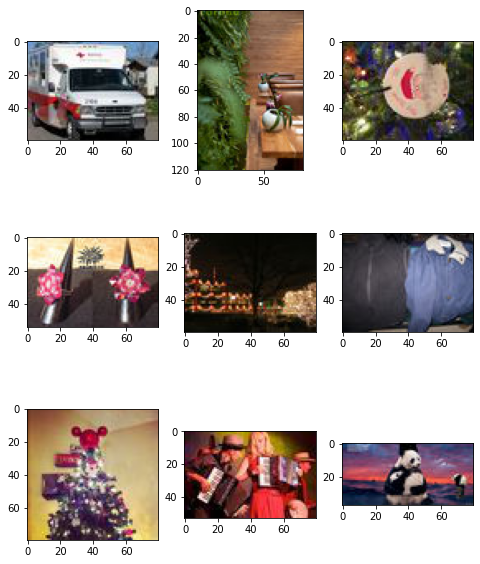

In [77]:
# Images in train dataset 

plt.figure(figsize=(8,10))

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    img=images[i]
    plt.imshow(img)
    
plt.show()

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2, rotation_range=45, horizontal_flip=True, vertical_flip=True,
         shear_range=0.2,  featurewise_center=True, zca_whitening=True)

In [21]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory=train_folder,
x_col="Image",
y_col="Class",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb',
class_mode="categorical",
target_size=(224,224))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory=train_folder,
x_col="Image",
y_col="Class",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb',
class_mode="categorical",
target_size=(224,224))


test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory=test_folder,
x_col="Image",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(224,224))

Found 5176 validated image filenames belonging to 6 classes.
Found 1293 validated image filenames belonging to 6 classes.
Found 3489 validated image filenames.


In [22]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Using transferr learning first we freeze the weights of the pretrained layers, at least at the beginning of training. 

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(6, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5, 
                  )

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
161/161 [==============================] - 76s 461ms/step - loss: 1.4902 - accuracy: 0.5981 - val_loss: 0.9652 - val_accuracy: 0.7445
Epoch 2/5
161/161 [==============================] - 73s 453ms/step - loss: 0.9734 - accuracy: 0.7328 - val_loss: 0.8311 - val_accuracy: 0.7406
Epoch 3/5
161/161 [==============================] - 73s 452ms/step - loss: 0.6645 - accuracy: 0.7691 - val_loss: 0.7945 - val_accuracy: 0.7344
Epoch 4/5
161/161 [==============================] - 73s 452ms/step - loss: 0.5431 - accuracy: 0.8108 - val_loss: 0.7531 - val_accuracy: 0.7500
Epoch 5/5
161/161 [==============================] - 73s 450ms/step - loss: 0.5663 - accuracy: 0.8027 - val_loss: 0.6606 - val_accuracy: 0.7602


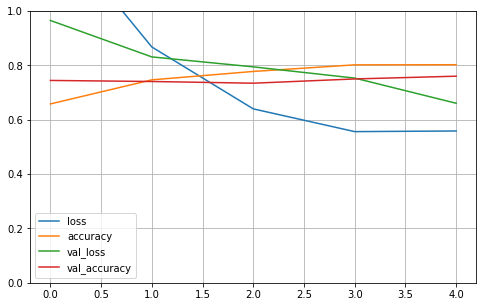

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

After training the model for a few epochs, its validation accuracy should reach about 75–80% and stop making much progress. This means that the top layers are now pretty well trained, so we are ready to unfreeze all the layers (or you could try unfreezing just the top ones) and continue training <br>
 This time we use a much
lower learning rate to avoid damaging the pretrained weights

In [ ]:
for layer in base_model.layers:
  layer.trainable = True
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20, callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
                  )

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
161/161 [==============================] - 126s 756ms/step - loss: 0.7371 - accuracy: 0.7340 - val_loss: 0.6486 - val_accuracy: 0.7898
Epoch 2/20
161/161 [==============================] - 120s 742ms/step - loss: 0.3519 - accuracy: 0.8738 - val_loss: 0.4859 - val_accuracy: 0.8180
Epoch 3/20
161/161 [==============================] - 119s 738ms/step - loss: 0.2448 - accuracy: 0.9140 - val_loss: 0.4059 - val_accuracy: 0.8578
Epoch 4/20
161/161 [==============================] - 119s 736ms/step - loss: 0.2162 - accuracy: 0.9235 - val_loss: 0.4281 - val_accuracy: 0.8570
Epoch 5/20
161/161 [==============================] - 119s 739ms/step - loss: 0.1732 - accuracy: 0.9384 - val_loss: 0.3918 - val_accuracy: 0.8742
Epoch 6/20
161/161 [==============================] - 119s 738ms/step - loss: 0.1254 - accuracy: 0.9541 - val_loss: 0.3798 - val_accuracy: 0.8773
Epoch 7/20
161/161 [==============================] - 120s 741ms/step - loss: 0.1128 - accuracy: 0.9607 - val_loss: 0.4109 -

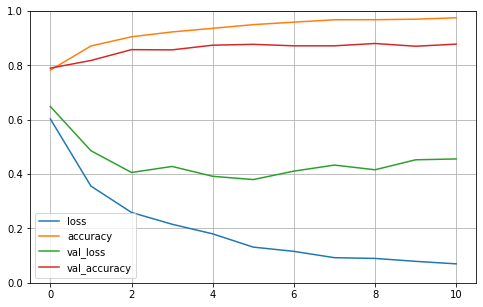

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
model.evaluate(valid_generator, steps=STEP_SIZE_TEST)

3489/3489 [==============================] - 15s 4ms/step - loss: 0.3869 - accuracy: 0.8739


[0.3869170546531677, 0.8739365935325623]

In [25]:
pred = model.predict(test_generator, steps=STEP_SIZE_TEST)

In [26]:
y_classes = pred.argmax(axis=-1)

To get the class names from numeric label   

In [27]:
train_generator.class_indices.items()

dict_items([('Airplane', 0), ('Candle', 1), ('Christmas_Tree', 2), ('Jacket', 3), ('Miscellaneous', 4), ('Snowman', 5)])

In [28]:
label_map = dict([(value, key) for key, value in train_generator.class_indices.items()]) 

In [29]:
labels = list(label_map.keys())

Lets Look at few of the predictions made by the trained model on the test images

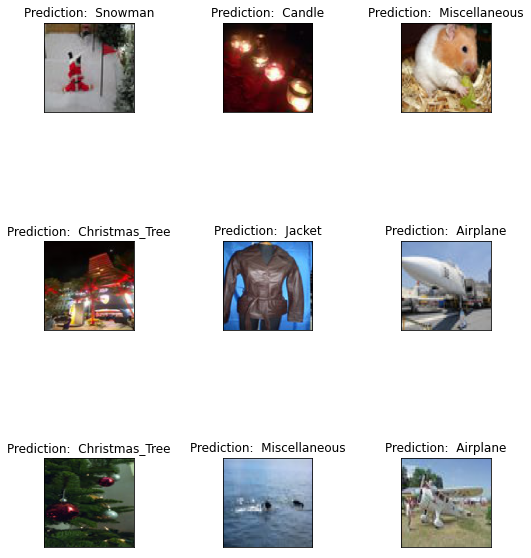

In [59]:
fig, axs = plt.subplots(3, 3, figsize = (8, 10))
fig.subplots_adjust(hspace = 1, wspace=1)
axs = axs.flatten()

for i, img in enumerate(test_generator):
    if i==9:
      break

    pred = model.predict(img)
    y_class = pred.argmax(axis=-1)
    # determine label for each prediction, set title
        
    title = 'Prediction:  {}'.format(label_map[y_class[0]])
    axs[i].set_title(title)
    axs[i].axes.get_xaxis().set_visible(False)
    axs[i].axes.get_yaxis().set_visible(False)
            
    # plot the image
    axs[i].imshow(img[0,:,:,:])
    

# show the plot
plt.show()

Lets make a csv file to submit our predictions

In [30]:
final_pred = []
for i in y_classes:
  final_pred.append(labels[i])

In [31]:
final_pred = pd.DataFrame(final_pred, columns=['Class'])

In [32]:
submission = pd.concat([test, final_pred], axis=1)

In [ ]:
#submission.to_csv('submission.csv', index=False)

In [ ]:
#model.save('model.h5')